📆 Analyzing data from 2019 to 2021

 Total titles (last 3 years): 5378
 Titles matching your preferences: 1915

Titles per Year:
year_added
2018       3
2019    1999
2020    1878
2021    1498
Name: show_id, dtype: int64

Type Distribution:
type
Movie      3702
TV Show    1676
Name: count, dtype: int64

Top Genres:
                      Genre  Count
0      International Movies   1593
1                    Dramas   1511
2                  Comedies   1135
3    International TV Shows    836
4        Action & Adventure    569
5                 TV Dramas    463
6  Children & Family Movies    439
7        Independent Movies    438
8           Romantic Movies    437
9             Documentaries    405

Top Countries:
country
United States     1748
Unknown            622
India              487
United Kingdom     200
Japan              162
South Korea        125
Egypt              105
Canada              94
Nigeria             91
Spain               80
Name: count, dtype: int64

Top Ratings:
ratin

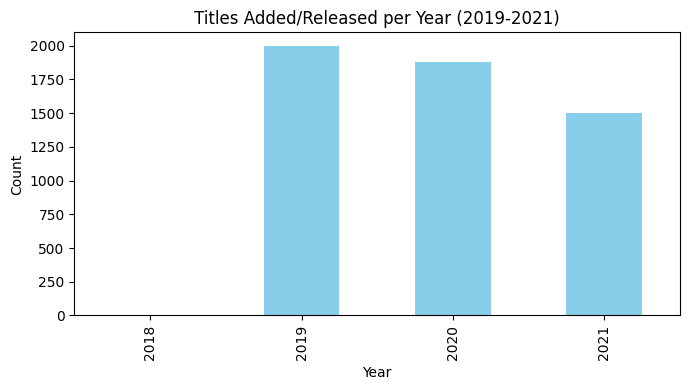

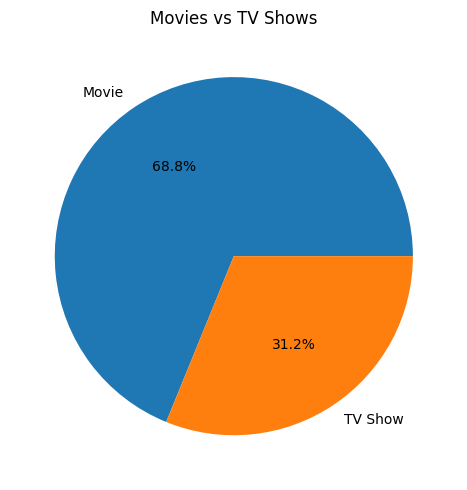

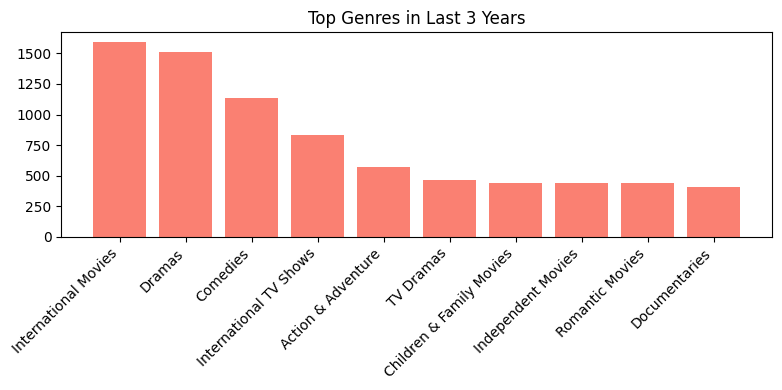

In [7]:
# netflix_data_analysis_last3years.py
# Performs 3-year data analysis based on Netflix dataset columns:
# show_id, type, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
from collections import Counter

# ---------- USER SETTINGS ----------
# Adjust these for your preferences
PREFERRED_GENRES = ["Dramas", "Documentaries"]   # or [] for all
PREFERRED_COUNTRIES = []                         # e.g. ["United States", "India"]
PREFERRED_TYPE = []                              # "Movie", "TV Show", or [] for both
PREFERRED_RATINGS = []                           # e.g. ["PG-13", "TV-MA"]
NUM_YEARS = 3                                    # Number of years to analyze
CSV_PATH = "netflix_titles.csv"                  # Path to your dataset file

# ---------- LOAD DATA ----------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f" CSV file not found: {CSV_PATH}. Please place 'netflix_titles.csv' in this folder.")

df = pd.read_csv(CSV_PATH)

expected_columns = [
    "show_id","type","title","director","cast","country",
    "date_added","release_year","rating","duration","listed_in","description"
]
missing = set(expected_columns) - set(df.columns)
if missing:
    raise ValueError(f"Dataset missing columns: {missing}")

# ---------- CLEAN + NORMALIZE ----------
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').astype('Int64')
df['country'] = df['country'].fillna("Unknown")
df['listed_in'] = df['listed_in'].fillna("")
df['genres'] = df['listed_in'].apply(lambda s: [g.strip() for g in s.split(',')] if s else [])

# ---------- DYNAMIC YEAR RANGE ----------
# Automatically detect latest available release year
max_year = int(df['release_year'].dropna().max())
end_year = max_year
start_year = end_year - NUM_YEARS + 1
years_to_include = list(range(start_year, end_year + 1))
print(f"📆 Analyzing data from {start_year} to {end_year}")

df_recent = df[
    df['release_year'].isin(years_to_include) |
    df['date_added'].dt.year.isin(years_to_include)
].copy()

# ---------- APPLY USER FILTERS ----------
df_filtered = df_recent.copy()

if PREFERRED_TYPE:
    df_filtered = df_filtered[df_filtered['type'].isin(PREFERRED_TYPE)]

if PREFERRED_RATINGS:
    df_filtered = df_filtered[df_filtered['rating'].isin(PREFERRED_RATINGS)]

if PREFERRED_COUNTRIES:
    df_filtered = df_filtered[df_filtered['country'].apply(
        lambda c: any(pref.lower() in c.lower() for pref in PREFERRED_COUNTRIES)
    )]

if PREFERRED_GENRES:
    df_filtered = df_filtered[df_filtered['genres'].apply(
        lambda gl: any(g.lower() in [x.lower() for x in gl] for g in PREFERRED_GENRES)
    )]

# ---------- SUMMARY STATS ----------
total_recent = len(df_recent)
total_filtered = len(df_filtered)

print(f"\n Total titles (last {NUM_YEARS} years): {total_recent}")
print(f" Titles matching your preferences: {total_filtered}")

# Year-wise count
df_recent['year_added'] = df_recent['date_added'].dt.year.fillna(df_recent['release_year'])
titles_per_year = df_recent.groupby('year_added')['show_id'].count().sort_index()

# Type distribution
type_dist = df_recent['type'].value_counts()

# Top genres
genre_counter = Counter()
for gl in df_recent['genres']:
    genre_counter.update(gl)
top_genres = pd.DataFrame(genre_counter.most_common(10), columns=["Genre", "Count"])

# Top countries
top_countries = df_recent['country'].value_counts().head(10)

# Ratings
top_ratings = df_recent['rating'].value_counts().head(10)

# ---------- DISPLAY OUTPUT ----------
print("\nTitles per Year:")
print(titles_per_year if not titles_per_year.empty else "No data available for these years.")

print("\nType Distribution:")
print(type_dist if not type_dist.empty else "No data available.")

print("\nTop Genres:")
print(top_genres if not top_genres.empty else "No data available.")

print("\nTop Countries:")
print(top_countries if not top_countries.empty else "No data available.")

print("\nTop Ratings:")
print(top_ratings if not top_ratings.empty else "No data available.")

# ---------- VISUALIZATIONS (Safe Plotting) ----------
if not titles_per_year.empty:
    plt.figure(figsize=(7,4))
    titles_per_year.plot(kind='bar', color='skyblue')
    plt.title(f"Titles Added/Released per Year ({start_year}-{end_year})")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("titles_per_year.png")
    print(" - Saved: titles_per_year.png")
else:
    print(" No yearly data to plot.")

if not type_dist.empty:
    plt.figure(figsize=(5,5))
    type_dist.plot(kind='pie', autopct="%1.1f%%", ylabel="")
    plt.title("Movies vs TV Shows")
    plt.tight_layout()
    plt.savefig("type_distribution.png")
    print(" - Saved: type_distribution.png")
else:
    print(" No type data to plot.")

if not top_genres.empty:
    plt.figure(figsize=(8,4))
    plt.bar(top_genres["Genre"], top_genres["Count"], color='salmon')
    plt.title("Top Genres in Last 3 Years")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("top_genres.png")
    print(" - Saved: top_genres.png")
else:
    print(" No genre data to plot.")

print("\n Analysis complete!")

# ---------- SAVE FILTERED DATA ----------
df_filtered.to_csv("netflix_filtered_last3years.csv", index=False)
print(f" Filtered data saved as 'netflix_filtered_last3years.csv' ({total_filtered} titles).")
